In [1]:
import os
import csv
import cv2
import sys 
import dlib
import time
import keras
import glob
import imutils
import platform
import datetime
import numpy as np
import collections
import tensorflow as tf
from keras.models import load_model
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

# Step 1: Load Image with Text

In [3]:
class ara_segmentation:
    def __init__(self, dir_txt_img):
        try:
            '''Display Environment Elements'''
            print("## Environment")
            print("OS: "+platform.system()+" "+platform.release()+" x"+platform.architecture()[0])
            print("Keras Version:",keras.__version__)
            print("TensorFlow Version:",tf.__version__)
            print("Opencv Version:",cv2.__version__)

            """
            Step1: Load Image
            """
            self.img = cv2.imread(dir_txt_img)
            self.img_h , self.img_w , _ = self.img.shape

            print("\nWord Image:")
            plt.figure()
            #plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
            plt.imshow(self.img)
            plt.show()
            print("\nProject Variables and Instances are Loaded successfully")

            """
            Step 2: Find Horizontal Text Line
            """
            _, self.txtLine_Index = self.getWordLine(self.img.copy())

            """
            Step 3: Remove any Letters' Dots and Hamza
            """
            self.txtImage_without_dots_hamza = self.remove_dh(self.img.copy(), self.txtLine_Index)

            """
            Step 4: Segment Word into Parts
            """
            self.keys, self.dic, self.loc_in_main_image = self.word2parts(self.txtImage_without_dots_hamza.copy())

            for i in range(0,len(self.keys)):
                plt.figure()
                self.colSums, _, _ =self.getVerticals(self.dic[self.keys[i]], (2,2))
                plt.plot(self.colSums)
                plt.figure()
                plt.imshow(self.dic[self.keys[i]])
                plt.show()

            for i in range (0,len(self.loc_in_main_image)):
                self.x =self.loc_in_main_image[i][0]
                self.w =self.loc_in_main_image[i][1]
                #self.img[0:self.img_h , self.x: self.x + 1] = (255,0,0)
                self.img[0:self.img_h , self.x + self.w: self.x + self.w +1] = (255,0,0)

            plt.figure()
            plt.imshow(self.img)
            plt.show()



            """
            Step 5: Segment Parts into Letters
            """
            self.part2letters(self.dic, self.keys, self.txtLine_Index)


        except Exception as e: 
            '''If any of the System variables or 
               instances didn't load, the system 
               terminates
            '''
            print(e)
            sys.exit()
            
    
    def getWordLine(self, txt_Image):
        '''
        Get Word Line Using Horizontal Projection
        Input: Processed Image, Word in Black and White background
        Return: Image of the word with the line drawn AND the Index of the row where the line is found
        '''  
        #Array list of summations of non-zero pixels of inverted image for EACH ROW
        rowSum = []

        h , w , _ = txt_Image.shape

        #take Copy of Input Image
        im_row = txt_Image.copy()

        #Invert the Image Copy
        inv = cv2.bitwise_not(im_row)

        #Loop on each row to get sum of non-zero pixels of inverted image
        for r in range(0,h):
            row = inv [r:r+1 , 0:w-1 ] ## inv -> im_row
            rowSum.append(np.count_nonzero (row))

        #get the INDEX of Peak Value of all Summations where the line is found
        rowIndex = rowSum.index(max(rowSum))

        # Draw the Line on the Input image
        cv2.line(txt_Image,(0,rowIndex),(w-1,rowIndex),(255,0,0),2)

        #show Image
        plt.figure()
        #plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.imshow(txt_Image)
        plt.show()
        #show Horizontal Projection Plot and Maximum Point (Text Line Position)
        plt.figure()
        #plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.title("Horizontal Projection Plot and Maximum Point (Text Line Position)")
        plt.plot(rowSum)
        plt.plot(rowIndex,max(rowSum),'ro')
        plt.show()
        #Display Text Line Index Value
        print ("Text Horizontal Line at Height Index (from the Top of the Image): ",rowIndex)

        return txt_Image, rowIndex
    
    def remove_dh(self, txtImage, txtLine_Index):
        h , w , _ = txtImage.shape

        #Invert the Image Copy
        invIm = cv2.bitwise_not(txtImage.copy())
        invIm = cv2.cvtColor(invIm , cv2.COLOR_BGR2GRAY)

        #Threshold the Image
        _, thresh = cv2.threshold(invIm.copy(), 127, 255, 0)

        #Get all Contours
        _, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        #print("Number of Contours found:", len(contours))

        #If the contour is located outside the txtLine_Index row, then remove it
        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            if not(txtLine_Index < (y+h) and txtLine_Index > y):
                txtImage[y:y+h , x:x+w] = (255)

        #Clean some small noises
        kernel = np.ones((2,2),np.uint8)
        newIm = cv2.dilate(txtImage,kernel,iterations = 1)

        plt.figure()
        #plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.imshow(newIm)

        return newIm
    
    def word2parts(self, txtImage):
        #Invert the Image Copy
        invIm = cv2.bitwise_not(txtImage.copy())
        invIm = cv2.cvtColor(invIm , cv2.COLOR_BGR2GRAY)
        #Threshold the Image
        _, thresh = cv2.threshold(invIm.copy(), 127, 255, 0)
        #Get all Contours
        _, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        print("Number of Parts found:", len(contours))
        #Create a Dictionary for segmented Parts, the dictionary keys are the x co-ordinates for each part
        parts = {}
        parts_locations_in_main_image = [] #[X Anchor, Part Width]
        for c in contours:
                x,_,w,_ = cv2.boundingRect(c)
                parts_locations_in_main_image.append([x,w])
                part = txtImage[0:self.img_h-1 , x:x+w]
                parts[x]=part
        #Sort the Dictionary so that the segemented parts arranged from right to left
        dic_parts = collections.OrderedDict(sorted(parts.items())[::-1])
        dic_keys = sorted (list(parts.keys()))[::-1]

        return dic_keys, dic_parts, parts_locations_in_main_image
    
    
    def part2letters(self, dic, keys, txtLine_Index):
        for k in range(0,len(keys)):

            im = dic[keys[k]]
            h , w , _ = im.shape
            clr = im.copy()
            im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY) 
            _, im = cv2.threshold(im.copy(), 127, 255, 0)
            im = cv2.blur(im,(4,4))

            upperBorderPoints = [0] * w
            curveStatus = [0] * w  

            for c in range(0,w):
                col = im [0:h , c:c+1 ]
                for i in range(0,len(col)): 
                    x = col[i][0]
                    if x != 255 : 
                        upperBorderPoints [c] = txtLine_Index - i
                        break

            plt.figure()
            plt.plot(upperBorderPoints)


            #status 0 ....stable
            #status 1 .... curves up
            #status -1 ..... curves down

            for i in range(1,len(upperBorderPoints)-1):
                fwd = upperBorderPoints [i + 1] - upperBorderPoints [i]
                bkwd = upperBorderPoints [i] - upperBorderPoints [i - 1]

                if bkwd == 0 :
                    curveStatus [i - 1] = 0
                if bkwd > 0 :
                    curveStatus [i - 1] = 1
                if bkwd < 0 :
                    curveStatus [i - 1] = -1

            #2D array to store [X-coord. to cut at, Y-coord. of the cutting Hight]
            cuts = []
            #Ups And Downs Flag
            flg = 0

            for i in range (len(curveStatus)-1 , -1 , -1):
                s = curveStatus [i]
                if s == 1 and flg == 0 : #Check for the First DOWN after all Previous UPs
                    flg = 1
                if s == -1 and flg == 1 : #Check for the First UP after all Previous DOWNs
                    cuts.append([i+1,upperBorderPoints[i+1]])
                    flg = 0

            cuts = np.array(cuts) 
            
            
            
            if len(cuts)==0:
                plt.figure()
                plt.imshow(clr)
                plt.show()
                
            elif len(cuts)==1:
                #
                plt.figure()
                plt.imshow(clr)
                plt.show()
                
            elif len(cuts)>1:
            
                y = cuts[: ,1] 
                x = cuts[: ,0] 
                plt.plot(x, y, 'ro')
                #plot the last cut in blue
                plt.plot(cuts[-1: ,0], cuts[-1: ,1], 'bo')
                plt.figure()
                
                max_before_last_cut = max(upperBorderPoints[x[-1]:x[-2]])
                max_after_last_cut = max(upperBorderPoints[0:x[-1]])
                
                if max_before_last_cut >= max_after_last_cut :
                    #remove cut
                    x = x[:-1]
            
                for i in range (0,len(x)): 
                    clr [0:h , x[i]: x[i] + 1] = (255,0,0)
                
                plt.figure()
                plt.imshow(clr)
                plt.show()
                
    
    def getVerticals(self,image, kernelsize):
        """
        Get the summations of non zero elements in each column (contains word) and zero elements in each column (spaces)
        Input: Processed Image, Word in Black and White background
        Return: sum of non zeros elements in each column (colsSum) and zero columns which are spaces (colsSpaces)	
        """
        colsSum = []
        colsSpaces = []
        h , w , l = image.shape
        #dilate the image
        kernel = np.ones(kernelsize, np.uint8)
        dil = cv2.dilate(image, kernel, iterations=1)
        #invert it
        inv = cv2.bitwise_not(dil)
        inv = cv2.cvtColor(inv ,  cv2.COLOR_BGR2GRAY) ##
        low = np.array([128])
        upper = np.array([255])
        inv = cv2.inRange(inv ,low , upper )
        #plt.figure()
        #plt.imshow(inv)
        #get sum of columns from dilated-Inverted image
        for c in range(0,w):
            col = inv [0:h , c:c+1 ]
            x = np.count_nonzero (col)
            colsSum.append(x)
            if x == 0 :
                colsSpaces.append(c)
        maxPeak = max(colsSum)
        return colsSum , colsSpaces ,maxPeak

## Environment
OS: Linux 4.4.0-130-generic x64bit
Keras Version: 2.1.6
TensorFlow Version: 1.8.0
Opencv Version: 3.1.0

Word Image:


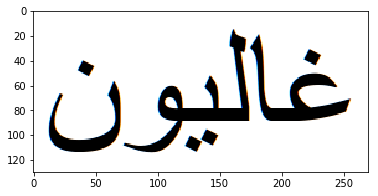


Project Variables and Instances are Loaded successfully


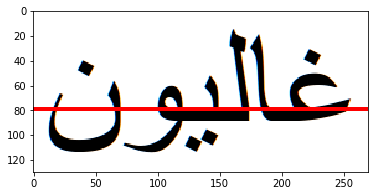

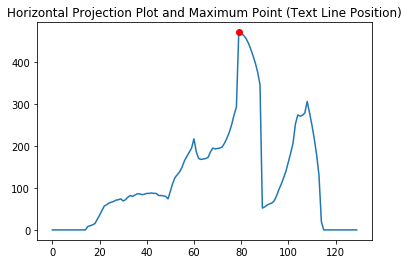

Text Horizontal Line at Height Index (from the Top of the Image):  79
Number of Parts found: 3


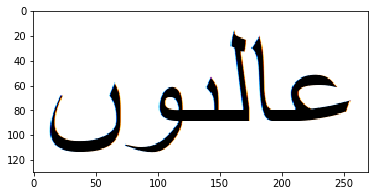

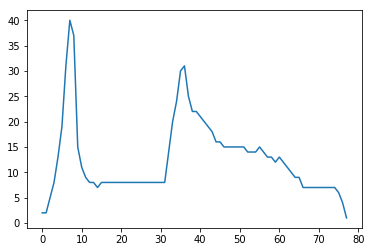

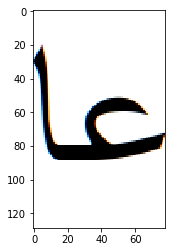

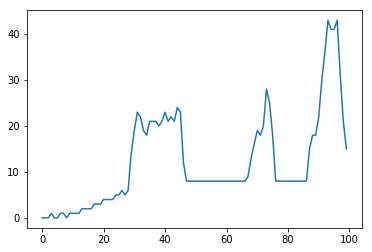

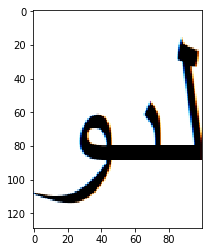

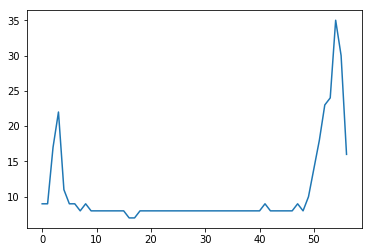

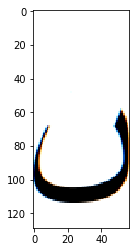

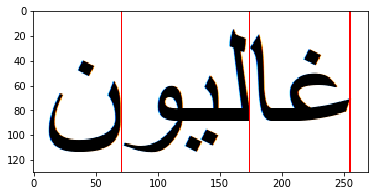

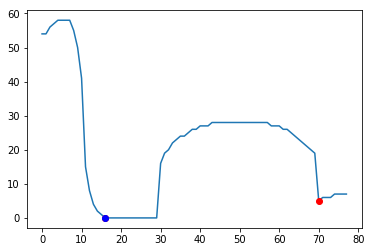

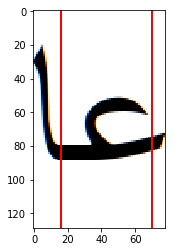

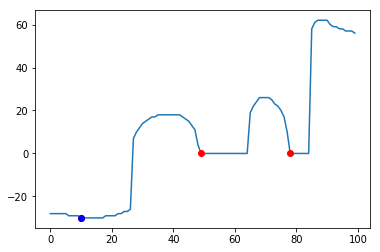

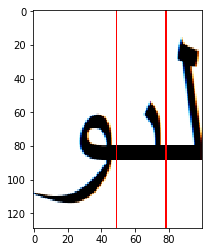

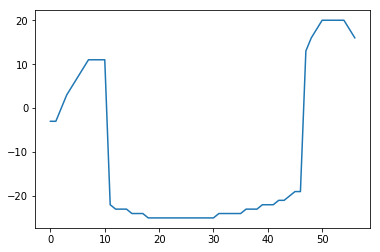

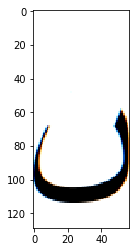

In [4]:
main_dir = "/media/mgd-pc/m.magdy.isl/E-Library/Mechatronics/AI/Datasets/singlewords/"
ara_segmentation(main_dir+"61.png")

# Step 5: Segment each part into letters

In [ ]:
#Get Row of pixels where the Word line is found
#Input: Processed Image, Word in Black and White background
#Return: List of Pixels of the Word Line Row
def getPixelsRow(rawimage , rowIndex):
    h , w = rawimage.shape
    #select the row
    row_of_pixels = rawimage [rowIndex:rowIndex + 1 , 0:w ]
    #Invert the row
    row_of_pixels = cv2.bitwise_not(row_of_pixels)
    #Convert the row to gray scale so it can be thresholded to two values 0/255
    #row_of_pixels = cv2.cvtColor(row_of_pixels , cv2.COLOR_BGR2GRAY) ##
    #loop on each pixel in the row to define its value even 0 or 255
    for i in range(0,len(row_of_pixels[0])):
        temp = row_of_pixels [0][i]
        if temp < 128:
            row_of_pixels [0][i] = 0
        elif temp > 128:
            row_of_pixels [0][i] = 255
    pixelsRow = row_of_pixels[0]

    return pixelsRow

In [ ]:
#Optimize the Row of Pixels Plot according to the ColsSum and define the coordinates where Underlined Letters are found
#Input: ColsSum and pixelsRow Lists
#Return: ULinedLettersSpaces List wher Underline Letters are found and new Optimized pixelsRow
def getULinedLettersSpaces (colsSum, pixelsRow):

    ULinedLettersSpaces = []
    for i in range (0 , len(pixelsRow)):
        temp0 = pixelsRow[i]
        if temp0 == 0 :
            temp1 = colsSum [i]
            if temp1 > 0 :
                pixelsRow[i] = 255
                ULinedLettersSpaces.append(i)
            elif temp1 == 0:
                pixelsRow[i] = 0

    return ULinedLettersSpaces, pixelsRow

In [ ]:
#Get the summations of non zero elements in each column (contains word) and zero elements in each column (spaces)
#Input: Processed Image, Word in Black and White background
#Return: sum of non zeros elements in each column (colsSum) and zero columns which are spaces (colsSpaces)
def getVerticals(image, kernelsize):
    colsSum = []
    colsSpaces = []
    h , w  = image.shape
    #dilate the image
    kernel = np.ones(kernelsize, np.uint8)
    dil = cv2.dilate(image, kernel, iterations=1)
    #invert it
    inv = cv2.bitwise_not(dil)
    #inv = cv2.cvtColor(inv ,  cv2.COLOR_BGR2GRAY) ##
    low = np.array([128])
    upper = np.array([255])
    inv = cv2.inRange(inv ,low , upper )
    plt.figure()
    plt.imshow(inv)
    #get sum of columns from dilated-Inverted image
    for c in range(0,w):
        col = inv [0:h , c:c+1 ]
        x = np.count_nonzero (col)
        colsSum.append(x)
        if x == 0 :
            colsSpaces.append(c)
    maxPeak = max(colsSum)
    return colsSum , colsSpaces ,maxPeak

In [ ]:
colsSum , colsSpaces ,maxPeak = getVerticals(im.copy(),(2,2))

In [ ]:
maxPeak

In [ ]:
txtLine_row = getPixelsRow(im.copy(),txtLine_Index)

In [ ]:
x,y = getULinedLettersSpaces(colsSum, txtLine_row)

In [ ]:
plt.plot(y)

In [ ]:
g = open('kk.txt','r') # What we know!
reviews = list(map(lambda x:x[:-1],g.readlines()))
g.close()


In [ ]:
from collections import Counter

In [ ]:
positive_counts = Counter()

for i in range(len(reviews)):
        for word in reviews[i].split(" "):
            positive_counts[word] += 1 
    


In [ ]:
len(positive_counts)

In [ ]:
len(positive_counts)